In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping
import math


In [26]:
# fix random seed for reproducibility
np.random.seed(7)

In [27]:
# dataframe = pd.read_csv('international-airline-passengers.csv',
#                         sep=';',          # Use semicolon as delimiter
#                         usecols=[1],      # Select the "Passengers" column
#                         engine='python')
# dataset = dataframe.values.astype('float32')


dataframe = pd.read_csv('international-airline-passengers.csv', sep=';', usecols=[1])
dataset = dataframe.values.astype('float32')

In [28]:
# Normalize the dataset
# scaler = MinMaxScaler(feature_range=(0, 1))
# dataset = scaler.fit_transform(dataset)

scaler = MinMaxScaler(feature_range=(0, 1))
dataset_scaled = scaler.fit_transform(dataset)


In [29]:
# Helper: create supervised learning data
def create_dataset(data, look_back=12):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back, 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

look_back = 12  # Use one year (if monthly) for strong seasonality learning

In [30]:
# Split into train and test sets

# train_size = int(len(dataset) * 0.67)
# test_size = len(dataset) - train_size
# train, test = dataset[:train_size], dataset[train_size:]
# print(f'Train size: {len(train)}, Test size: {len(test)}')

train_size = int(len(dataset_scaled) * 0.67)
test_size = len(dataset_scaled) - train_size
train, test = dataset_scaled[:train_size], dataset_scaled[train_size:]
print(f'Train size: {len(train)}, Test size: {len(test)}')


Train size: 96, Test size: 48


In [32]:
# Convert to supervised learning format

# def create_dataset(dataset, look_back=1):
#     dataX, dataY = [], []
#     for i in range(len(dataset) - look_back - 1):
#         a = dataset[i:(i + look_back), 0]
#         dataX.append(a)
#         dataY.append(dataset[i + look_back, 0])
#     return np.array(dataX), np.array(dataY)



In [34]:
# Prepare the train and test datasets

# look_back = 1
# trainX, trainY = create_dataset(train, look_back)
# testX, testY = create_dataset(test, look_back)

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [35]:
# Reshape input to [samples, time steps, features]

# trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
# testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

trainX = trainX.reshape((trainX.shape[0], look_back, 1))
testX = testX.reshape((testX.shape[0], look_back, 1))


In [36]:
# Create and fit the LSTM network

# model = Sequential()
# model.add(LSTM(4, input_shape=(1, look_back)))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error', optimizer='adam')
# model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

# Build LSTM model (deeper + regularization)
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(look_back, 1)),
    Dropout(0.2),
    LSTM(25),
    Dense(1)
])
model.compile(loss='mean_squared_error', optimizer='adam')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [37]:
# Early stopping for practical training & deployment
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    trainX, trainY,
    epochs=150,
    batch_size=16,
    validation_data=(testX, testY),
    callbacks=[early_stop],
    verbose=2
)

Epoch 1/150
6/6 - 4s - 590ms/step - loss: 0.0511 - val_loss: 0.1411
Epoch 2/150
6/6 - 0s - 30ms/step - loss: 0.0122 - val_loss: 0.0218
Epoch 3/150
6/6 - 0s - 27ms/step - loss: 0.0128 - val_loss: 0.0250
Epoch 4/150
6/6 - 0s - 22ms/step - loss: 0.0074 - val_loss: 0.0544
Epoch 5/150
6/6 - 0s - 32ms/step - loss: 0.0076 - val_loss: 0.0496
Epoch 6/150
6/6 - 0s - 51ms/step - loss: 0.0068 - val_loss: 0.0291
Epoch 7/150
6/6 - 0s - 35ms/step - loss: 0.0052 - val_loss: 0.0229
Epoch 8/150
6/6 - 0s - 34ms/step - loss: 0.0052 - val_loss: 0.0239
Epoch 9/150
6/6 - 0s - 54ms/step - loss: 0.0048 - val_loss: 0.0222
Epoch 10/150
6/6 - 0s - 66ms/step - loss: 0.0048 - val_loss: 0.0207
Epoch 11/150
6/6 - 1s - 110ms/step - loss: 0.0048 - val_loss: 0.0211
Epoch 12/150
6/6 - 1s - 97ms/step - loss: 0.0044 - val_loss: 0.0204
Epoch 13/150
6/6 - 1s - 92ms/step - loss: 0.0052 - val_loss: 0.0203
Epoch 14/150
6/6 - 0s - 56ms/step - loss: 0.0044 - val_loss: 0.0231
Epoch 15/150
6/6 - 0s - 50ms/step - loss: 0.0047 - val_

In [38]:
# Make predictions

# trainPredict = model.predict(trainX)
# testPredict = model.predict(testX)

# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [39]:
# Invert predictions back to original scale

# trainPredict = scaler.inverse_transform(trainPredict)
# trainY = scaler.inverse_transform(trainY.reshape(-1, 1))
# testPredict = scaler.inverse_transform(testPredict)
# testY = scaler.inverse_transform(testY.reshape(-1, 1))

trainPredict = scaler.inverse_transform(trainPredict)
trainY_inv = scaler.inverse_transform(trainY.reshape(-1, 1))
testPredict = scaler.inverse_transform(testPredict)
testY_inv = scaler.inverse_transform(testY.reshape(-1, 1))

In [40]:
# Calculate RMSE

# trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
# testScore = math.sqrt(mean_squared_error(testY, testPredict))
# print(f'Train RMSE: {trainScore:.2f}')
# print(f'Test RMSE: {testScore:.2f}')


trainScore = math.sqrt(mean_squared_error(trainY_inv, trainPredict))
testScore = math.sqrt(mean_squared_error(testY_inv, testPredict))
print(f'Train RMSE: {trainScore:.2f}')
print(f'Test RMSE: {testScore:.2f}')

Train RMSE: 24.87
Test RMSE: 57.21


In [41]:
# Shift train predictions for plotting

# trainPredictPlot = np.empty_like(dataset)
# trainPredictPlot[:, :] = np.nan
# trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict

trainPredictPlot = np.empty_like(dataset_scaled)
trainPredictPlot[:] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, 0] = trainPredict[:, 0]

In [43]:
# Shift test predictions for plotting

# testPredictPlot = np.empty_like(dataset)
# testPredictPlot[:, :] = np.nan
# testPredictPlot[len(trainPredict) + (look_back * 2) + 1:len(dataset) - 1, :] = testPredict


testPredictPlot = np.empty_like(dataset_scaled)
testPredictPlot[:] = np.nan
start_idx = len(trainPredict) + look_back
stop_idx = start_idx + len(testPredict)
testPredictPlot[start_idx:stop_idx, 0] = testPredict[:, 0]


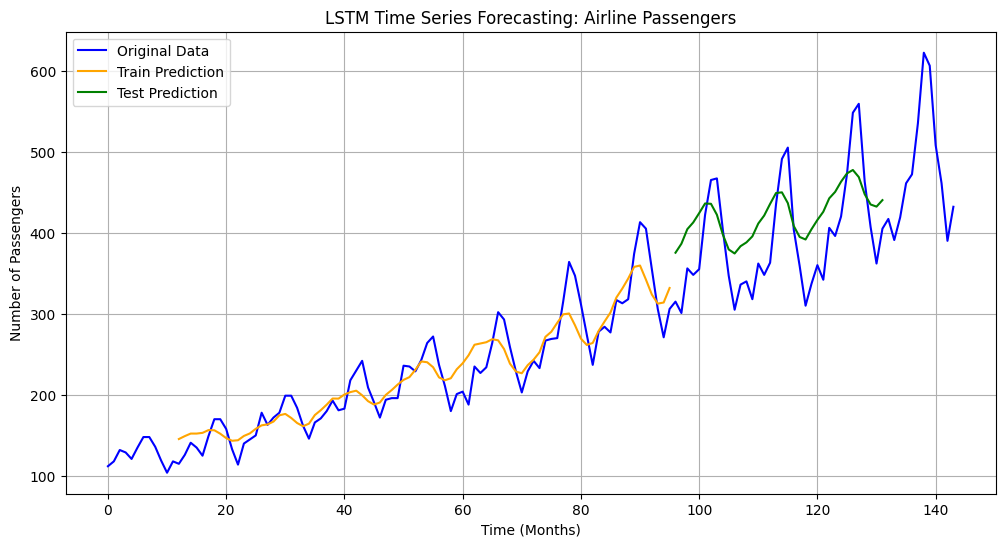

In [44]:
# Plot baseline and predictions

# plt.plot(scaler.inverse_transform(dataset), label='Original Data')
# plt.plot(trainPredictPlot, label='Train Prediction')
# plt.plot(testPredictPlot, label='Test Prediction')
# plt.legend()
# plt.show()

plt.figure(figsize=(12,6))
plt.plot(scaler.inverse_transform(dataset_scaled), label='Original Data', color='blue')
plt.plot(trainPredictPlot, label='Train Prediction', color='orange')
plt.plot(testPredictPlot, label='Test Prediction', color='green')
plt.title('LSTM Time Series Forecasting: Airline Passengers')
plt.xlabel('Time (Months)')
plt.ylabel('Number of Passengers')
plt.legend()
plt.grid(True)
plt.show()

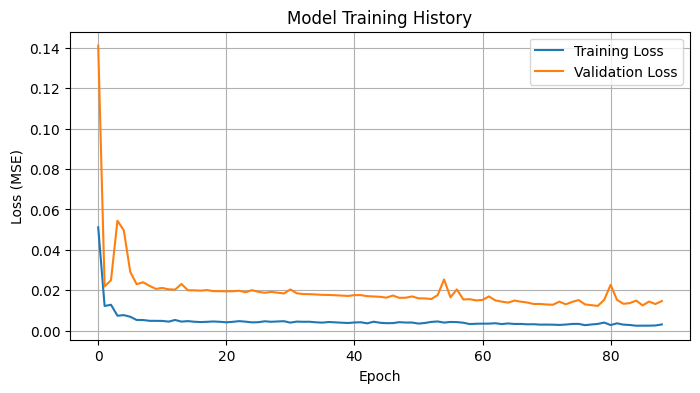

In [45]:
# Plot training history
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()